## <span style="color:red">*Exercise 1*</span>


In [61]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [62]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import pandas as pd
neg_df = pd.read_csv('comments_negative.csv', chunksize=5000)
for i in neg_df:
  neg_df = i
  break
pos_df = pd.read_csv('comments_positive.csv', chunksize=5000)
for i in pos_df:
  pos_df = i
  break

In [67]:
df = pd.concat([pos_df[['text']], neg_df[['text']]], axis=0, ignore_index=True)
df['label'] = [1] * 5000 + [0] * 5000
df

,text,label
0,This isn't Twitter: try to comment on the arti...,1
1,"Well, it is exactly what it sounds like. It's ...",1
2,"In soviet Russia, bomb disarms you!",1
3,"""runin for senitur! #YOLO!""",1
4,You step motherfucker.,1
...,...,...
9995,Devil's advocate here for sake of argument. W...,0
9996,Are you reading with your ears? xD Hes talking...,0
9997,Gay man here who visits TRP decently often: i...,0
9998,PSY,0


In [0]:
sentences = df.text.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [69]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])


Tokenize the first sentence:
['[CLS]', 'this', 'isn', "'", 't', 'twitter', ':', 'try', 'to', 'comment', 'on', 'the', 'article', ',', 'and', 'not', 'your', 'current', 'activities', '.', '[SEP]']


In [70]:
MAX_LEN = 256
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [0]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2020, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2020, test_size=0.1)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

In [0]:
vocab_in_size = tokenizer.vocab_size
embedding_dim = 32
unit = 100
no_labels = len(np.unique(train_labels))
batch_size = 32

In [75]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm.add(LSTM(unit))
model_lstm.add(Dense(no_labels, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 32)           976704    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 1,030,106
Trainable params: 1,030,106
Non-trainable params: 0
_________________________________________________________________


In [76]:
history_lstm = model_lstm.fit(train_inputs, train_labels, 
                              epochs=10,batch_size=batch_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





9000/9000 [==============================] - 136s 15ms/step - loss: 0.6935 - acc: 0.5062
Epoch 2/10
9000/9000 [==============================] - 128s 14ms/step - loss: 0.6930 - acc: 0.5018
Epoch 3/10
9000/9000 [==============================] - 128s 14ms/step - loss: 0.6977 - acc: 0.5130
Epoch 4/10
9000/9000 [==============================] - 128s 14ms/step - loss: 0.6983 - acc: 0.4949
Epoch 5/10
9000/9000 [==============================] - 127s 14ms/step - loss: 0.6931 - acc: 0.5141
Epoch 6/10
9000/9000 [==============================] - 127s 14ms/step - loss: 0.6916 - acc: 0.5061
Epoch 7/10
9000/9000 [==============================] - 127s 14ms/step - loss: 0.6893 - acc: 0.5061
Epoch 8/10
9000/9000 [==============================] - 127s 14ms/step - loss: 0.6895 - acc: 0.5109
Epoch 9/10
9000/9000 [==============================] - 127s 14ms/step - loss: 0.6867 - acc: 0.520

The accuracy of this model is around 0.52, which is apparently not good.


In [0]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [79]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [0]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [85]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    282.    Elapsed: 0:00:31.
  Batch    80  of    282.    Elapsed: 0:01:02.
  Batch   120  of    282.    Elapsed: 0:01:33.
  Batch   160  of    282.    Elapsed: 0:02:04.
  Batch   200  of    282.    Elapsed: 0:02:35.
  Batch   240  of    282.    Elapsed: 0:03:06.
  Batch   280  of    282.    Elapsed: 0:03:37.

  Average training loss: 0.56
  Training epcoh took: 0:03:38

Running Validation...
  Accuracy: 0.76
  Validation took: 0:00:08

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    282.    Elapsed: 0:00:31.
  Batch    80  of    282.    Elapsed: 0:01:02.
  Batch   120  of    282.    Elapsed: 0:01:33.
  Batch   160  of    282.    Elapsed: 0:02:04.
  Batch   200  of    282.    Elapsed: 0:02:35.
  Batch   240  of    282.    Elapsed: 0:03:06.
  Batch   280  of    282.    Elapsed: 0:03:37.

  Average training loss: 0.40
  Training epcoh took: 0:03:38

Running Validation...
  Accuracy: 0.78
  Validation took: 0:00:0

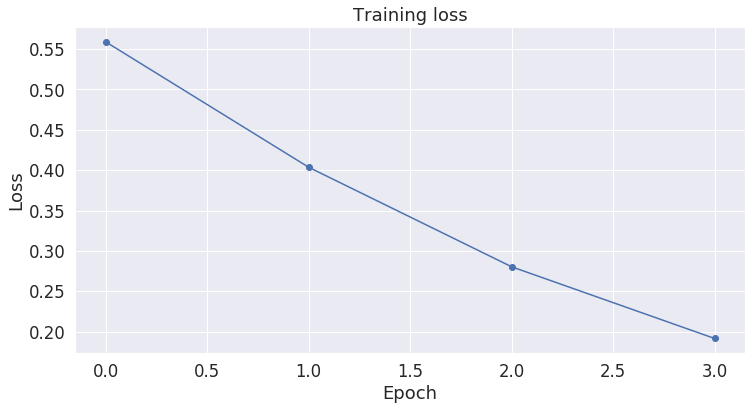

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [0]:
neg_pred = pd.read_csv('comments_negative.csv', chunksize=5000)
count = 0
for i in neg_pred:
  count += 1
  if count == 2:
    break
neg_pred = i
pos_pred = pd.read_csv('comments_positive.csv', chunksize=5000)
count = 0
for i in pos_pred:
  count += 1
  if count == 2:
    break
pos_pred = i
df_pred = pd.concat([pos_pred[['text']], neg_pred[['text']]], axis=0, ignore_index=True)
df_pred['label'] = [1] * 5000 + [0] * 5000

In [88]:
sentences = df_pred.text.values
labels = df_pred.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Token indices sequence length is longer than the specified maximum sequence length for this model (868 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1420 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (813 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (562 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

In [89]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 10,000 test sentences...
    DONE.


In [90]:
print('Positive samples: %d of %d (%.2f%%)' % (df_pred.label.sum(), len(df_pred.label), (df_pred.label.sum() / len(df_pred.label) * 100.0)))

Positive samples: 5000 of 10000 (50.00%)


In [91]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
    matthews_set.append(matthews)

matthews_set

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4414147946478204,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 

In [92]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.516


The performance of the model is quite good, which shows that there is a strong relationship between the actual labels and our predicted labels. We can to some degree predict other Reddit comments' voting signs(positive or negative) based on known data. Compared with the model produced by Keras, this one performs obviously better

## <span style="color:red">*Exercise 2*</span>

In [0]:
df2 = pd.concat([pos_df[['text', 'parent_text']], neg_df[['text', 'parent_text']]], axis=0, ignore_index=True)
text = df2.text
par_text = df2.parent_text
text = ["[CLS] " + sentence + " [SEP]" for sentence in text]
par_text = ["[CLS] " + sentence + " [SEP]" for sentence in par_text]

In [94]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_text = [tokenizer.tokenize(sent) for sent in text]
tokenized_par = [tokenizer.tokenize(sent) for sent in par_text]

print (tokenized_text[0])

['[CLS]', 'this', 'isn', "'", 't', 'twitter', ':', 'try', 'to', 'comment', 'on', 'the', 'article', ',', 'and', 'not', 'your', 'current', 'activities', '.', '[SEP]']


In [0]:
indexed_tokens = [tokenizer.convert_tokens_to_ids(text) for text in tokenized_text]
indexed_par = [tokenizer.convert_tokens_to_ids(text) for text in tokenized_par]

In [0]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

In [0]:
indexed_tokens = pad_sequences(indexed_tokens, maxlen=128, dtype="long", truncating="post", padding="post")
indexed_par = pad_sequences(indexed_par, maxlen=128, dtype="long", truncating="post", padding="post")

In [0]:
seg_ids = [128 * [1] for _ in tokenized_text]
par_seg_ids = [128 * [1] for _ in tokenized_par]

In [0]:
tokens_tensor = torch.tensor(indexed_tokens[:70])
par_tokens_tensor = torch.tensor(indexed_par[:70])
seg_tensor = torch.tensor(seg_ids[:70])
par_seg_tensor = torch.tensor(par_seg_ids[:70])

In [100]:
from transformers import BertModel
model_embedding = BertModel.from_pretrained('bert-base-uncased')

model_embedding.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [0]:
output = model_embedding(tokens_tensor, seg_tensor)
par_output = model_embedding(par_tokens_tensor, par_seg_tensor)

In [0]:
word_embeddings, sentence_embedding = output
word_embeddings_par, sentence_embedding_par = par_output

In [0]:
from scipy.spatial.distance import cosine
l = len(sentence_embedding.detach().numpy())
embedding_cosine = [1 - cosine(sentence_embedding[i].detach().numpy(), sentence_embedding_par[i].detach().numpy()) for i in range(l)]

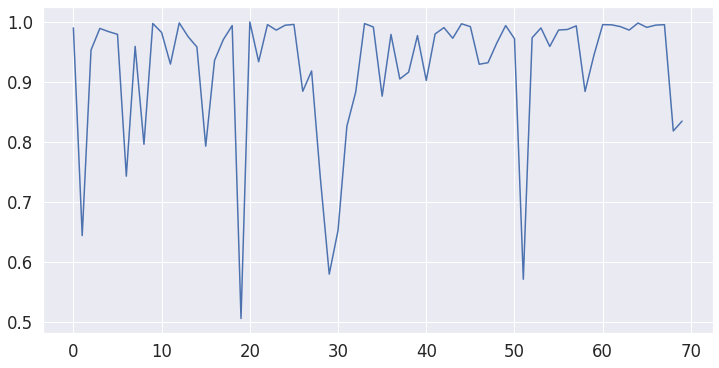

In [104]:
plt.plot(embedding_cosine);


As the above plot shows, the cosine similarities between comments and their parent comments are nearly all above 0.8 with only 5 exceptions. Thus we can conclude that there is always a high similarity between comments and their corresponding parent comments in the term of embedding. 

In [105]:
from transformers import pipeline
nlp_sentiment = pipeline('sentiment-analysis')

In [0]:

text_senti = [nlp_sentiment(text) for text in df2.text[:500]]
par_senti = [nlp_sentiment(text) for text in df2.parent_text[:500]]

In [0]:
senti_diff = [abs(i[0]['score'] - j[0]['score']) for i, j in zip(text_senti, par_senti)]

In [108]:
max(senti_diff), min(senti_diff)

(0.49875093, 3.2007694e-05)

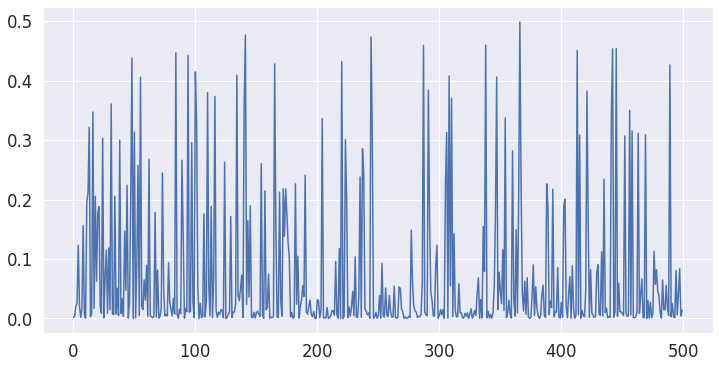

In [110]:
plt.plot(senti_diff);

Through the analyses of the sentimental scores of comments and parent comments, we find that the largest difference between a comment and its parent comment is below 0.5, which suggests that comments are mostly sentimentally similar to their parent comments. 

## <span style="color:red">*Exercise 3*</span>

In [0]:
torch.cuda.empty_cache() 

In [0]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(pos_df['text'], test_size=0.2)

In [0]:
train_text.to_frame().to_csv(r'train_text', header=None, index=None, sep=' ', mode='a')
test_text.to_frame().to_csv(r'test_text', header=None, index=None, sep=' ', mode='a')

In [44]:
!python /content/run_language_modelling.py --output_dir=output_gpt_text --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text --do_eval --eval_data_file=test_text --per_gpu_train_batch_size=1 --per_gpu_eval_batch_size=1 --overwrite_output_dir

03/06/2020 15:37:28 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
03/06/2020 15:37:28 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /root/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.699bbd1c449e9861456f359d6daa51bd523ac085b4b531ab0aad5a55d091e942
03/06/2020 15:37:28 - INFO - transformers.configuration_utils -   Model config GPT2Config {
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "embd_pdrop": 0.1,
  "eos_token_ids": null,
  "finetuning_task": null,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_epsilon": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20

In [45]:
!python run_generation.py --model_type=gpt2 --model_name_or_path=output_gpt_text

03/06/2020 15:39:34 - INFO - transformers.tokenization_utils -   Model name 'output_gpt_text' not found in model shortcut name list (gpt2, gpt2-medium, gpt2-large, gpt2-xl, distilgpt2). Assuming 'output_gpt_text' is a path, a model identifier, or url to a directory containing tokenizer files.
03/06/2020 15:39:34 - INFO - transformers.tokenization_utils -   Didn't find file output_gpt_text/added_tokens.json. We won't load it.
03/06/2020 15:39:34 - INFO - transformers.tokenization_utils -   loading file output_gpt_text/vocab.json
03/06/2020 15:39:34 - INFO - transformers.tokenization_utils -   loading file output_gpt_text/merges.txt
03/06/2020 15:39:34 - INFO - transformers.tokenization_utils -   loading file None
03/06/2020 15:39:34 - INFO - transformers.tokenization_utils -   loading file output_gpt_text/special_tokens_map.json
03/06/2020 15:39:34 - INFO - transformers.tokenization_utils -   loading file output_gpt_text/tokenizer_config.json
03/06/2020 15:39:34 - INFO - transformers.co

In [0]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

tokenizer_reddit = AutoTokenizer.from_pretrained("output_gpt_text")
model_reddit = AutoModelWithLMHead.from_pretrained("output_gpt_text")

In [58]:
sequence = "life is"

input = tokenizer_reddit.encode(sequence, return_tensors="pt")
generated = model_reddit.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_reddit.decode(generated.tolist()[0])
print(resulting_string)

life is the ultimate battle to live through," said his daughter on Instagram. "You really gotta come through. "

"


In [60]:
sequence = "politics are"

input = tokenizer_reddit.encode(sequence, return_tensors="pt")
generated = model_reddit.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_reddit.decode(generated.tolist()[0])
print(resulting_string)

politics are still working to bring forward a good-faith proposal that would be in the best interests of every single citizen – the Constitution, the First Amendment, and the human rights of all."
"


The results of text generation are surprisingly interpretable. Given that e use the comments with upvotes here, we naturally assume that there will be more positive expressions in those comments. The generated text following "life is" validate our assumption. It compares the life to an ultimate battle but also teaches us not to give up.  

## <span style="color:red">*Exercise 4*</span>

In [0]:
torch.cuda.empty_cache() 

In [0]:
train_text, test_text = train_test_split(neg_df['text'], test_size=0.2)
train_text.to_frame().to_csv(r'train_lr', header=None, index=None, sep=' ', mode='a')
test_text.to_frame().to_csv(r'test_lr', header=None, index=None, sep=' ', mode='a')

In [51]:
!python /content/run_language_modelling.py --output_dir=output_gpt_lr --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_lr --do_eval --eval_data_file=test_lr --per_gpu_train_batch_size=1 --per_gpu_eval_batch_size=1

03/06/2020 15:40:08 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
03/06/2020 15:40:08 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /root/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.699bbd1c449e9861456f359d6daa51bd523ac085b4b531ab0aad5a55d091e942
03/06/2020 15:40:08 - INFO - transformers.configuration_utils -   Model config GPT2Config {
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "embd_pdrop": 0.1,
  "eos_token_ids": null,
  "finetuning_task": null,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_epsilon": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20

In [52]:
!python run_generation.py --model_type=gpt2 --model_name_or_path=output_gpt_lr

03/06/2020 15:42:02 - INFO - transformers.tokenization_utils -   Model name 'output_gpt_lr' not found in model shortcut name list (gpt2, gpt2-medium, gpt2-large, gpt2-xl, distilgpt2). Assuming 'output_gpt_lr' is a path, a model identifier, or url to a directory containing tokenizer files.
03/06/2020 15:42:02 - INFO - transformers.tokenization_utils -   Didn't find file output_gpt_lr/added_tokens.json. We won't load it.
03/06/2020 15:42:02 - INFO - transformers.tokenization_utils -   loading file output_gpt_lr/vocab.json
03/06/2020 15:42:02 - INFO - transformers.tokenization_utils -   loading file output_gpt_lr/merges.txt
03/06/2020 15:42:02 - INFO - transformers.tokenization_utils -   loading file None
03/06/2020 15:42:02 - INFO - transformers.tokenization_utils -   loading file output_gpt_lr/special_tokens_map.json
03/06/2020 15:42:02 - INFO - transformers.tokenization_utils -   loading file output_gpt_lr/tokenizer_config.json
03/06/2020 15:42:02 - INFO - transformers.configuration_ut

In [0]:
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer
hr_model_embedding = RobertaModel.from_pretrained('output_gpt_text')
hr_tokenizer = RobertaTokenizer.from_pretrained('output_gpt_text')

In [0]:
import seaborn as sns
from scipy.spatial.distance import cosine
def visualise_diffs(text, model, tokenizer):
    word_vecs = []
    for i in range(0, len(text.split())):
        word_vecs.append(word_vector(text, i, model, tokenizer))
    L = []
    for p in word_vecs:
        l = []
        for q in word_vecs:
            l.append(1 - cosine(p, q))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(text.split()), index = list(text.split()))
    ax = sns.heatmap(div)
    plt.show()

def word_vector(text, word_id, model, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings, sentence_embeddings = model(tokens_tensor)   
    vector = word_embeddings[0][word_id].detach().numpy()
    return vector

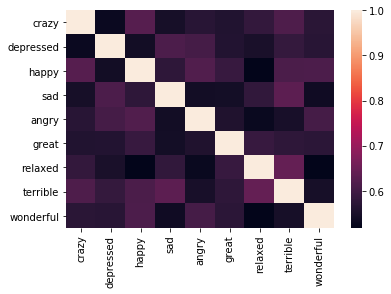

In [55]:
text = "crazy depressed happy sad angry great relaxed terrible wonderful" 
visualise_diffs(text, hr_model_embedding, hr_tokenizer)

In [0]:
lr_model_embedding = RobertaModel.from_pretrained('output_gpt_lr')
lr_tokenizer = RobertaTokenizer.from_pretrained('output_gpt_lr')

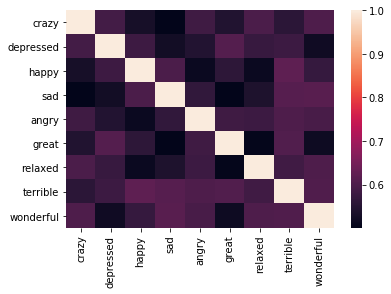

In [57]:
visualise_diffs(text, lr_model_embedding, lr_tokenizer)

We split the dataset into two parts, one with high response rates (votes) and another with low response rates. We assume that those with high response rates are more emotional so that they either have more resonance for those users or can incur more criticisms. But according to the above graphs, the comments with comparatively low response rates have more light spots than the ones with higher response rates, which means that it is more common to use emotional expressions in those comments. Almost no light spots mean that emotional expressions hardly ever appears in highly-voted comments so the model cannot reasonably tell the difference between those words  